In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# source files
import sys
sys.path.append('scripts/')
from calibrated_regression import CalibratedRegression
from data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

(1250,) (250,) (1250,) (250,)


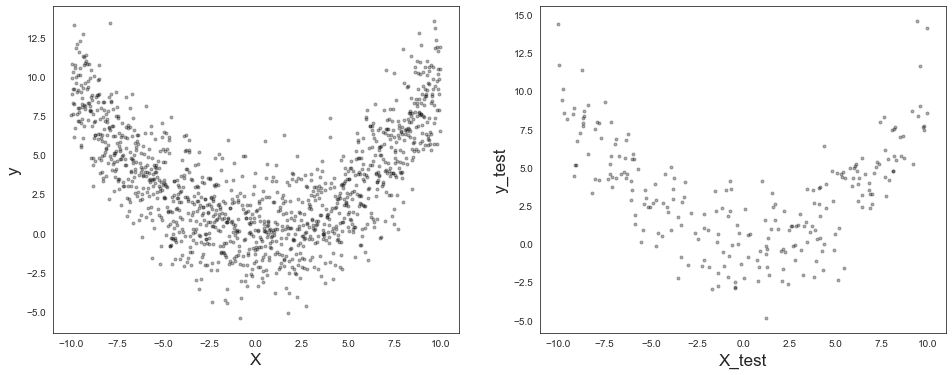

In [2]:
X, X_test, y, y_test = load_quadratic_data()
print(X.shape, X_test.shape, y.shape, y_test.shape)

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

In [3]:
with pm.Model() as model:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f_x = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f_x, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, b, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1799.14draws/s]
/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098186,0.000953,0.000019,0.096322,0.100017,2422.225795,0.999965
b,-0.017850,0.004886,0.000095,-0.027161,-0.008131,2660.549525,0.999776
c,-0.001751,0.042655,0.000808,-0.082370,0.081303,2646.951164,0.999872


In [4]:
def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

In [5]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]
print(calib.predict_quantiles(quants))

,X,y,predicted_cdf,empirical_cdf
0,-6.130754,3.720960,0.478333,0.444
1,-1.527685,0.968249,0.767000,0.664
2,7.344897,3.880059,0.101000,0.276
3,-2.301534,0.438840,0.457000,0.428
4,0.020013,-0.862601,0.197000,0.324


[5.55555556e-05 5.35666667e-01 9.98083333e-01]


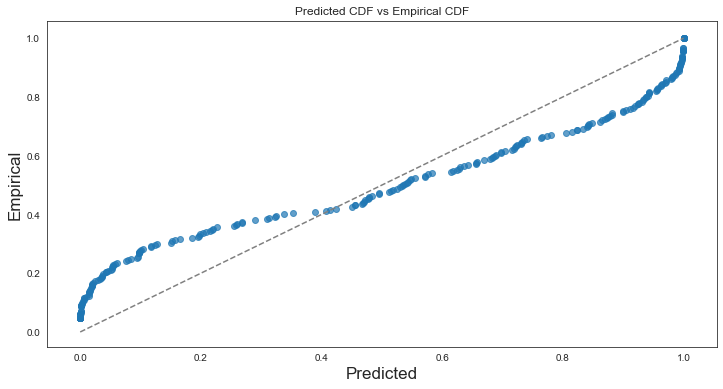

In [6]:
# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax)

In [7]:
# prediction
post_pred_test, new_quantiles = calib.predict(X_test, y_test, quants)
cal_lower, cal_median, cal_upper = np.quantile(post_pred_test, new_quantiles, axis=1)
unc_lower, unc_median, unc_upper = np.quantile(post_pred_test, quants, axis=1)
perc_within_unc = np.mean((y_test <= unc_upper)&(y_test >= unc_lower))
perc_within_cal = np.mean((y_test <= cal_upper)&(y_test >= cal_lower))

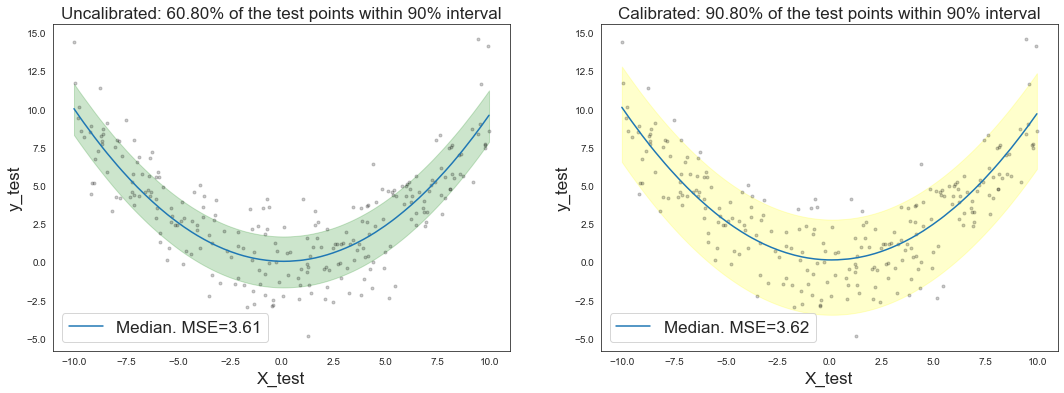

In [8]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax[0].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[0].set_title(f'Uncalibrated: {100*perc_within_unc:.2f}% of the test points within 90% interval', fontsize=17)
ax[0].set_xlabel('X_test', fontsize=17)
ax[0].set_ylabel('y_test', fontsize=17)
ax[0].fill_between(X_test, unc_lower, unc_upper, color='green', alpha=0.2)
ax[0].plot(X_test, unc_median, label=f'Median. MSE={mean_squared_error(y_test, unc_median):.2f}')
ax[0].legend(fontsize=17)

ax[1].plot(X_test, y_test, 'o', color='black', alpha=0.2, markersize=3)
ax[1].set_title(f'Calibrated: {100*perc_within_cal:.2f}% of the test points within 90% interval', fontsize=17)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17)
ax[1].fill_between(X_test, cal_lower, cal_upper, color='yellow', alpha=0.2)
ax[1].plot(X_test, cal_median, label=f'Median. MSE={mean_squared_error(y_test, cal_median):.2f}')
ax[1].legend(fontsize=17);

In [9]:
# # diagnostic plot
# conf_levels = np.arange(start=0.025, stop=0.5, step=0.025)
# cls = 1-2*conf_levels
# unc_pcts = []
# cal_pcts = []

# for cl in conf_levels:
#     quants = [cl, 1-cl]
#     post_pred_test, new_quantiles = calib.predict(X_test, y_test, quants)
    
#     cal_lower, cal_upper = np.quantile(post_pred_test, new_quantiles, axis=1)
#     unc_lower, unc_upper = np.quantile(post_pred_test, quants, axis=1)
    
#     perc_within_unc = np.mean((y_test <= unc_upper)&(y_test >= unc_lower))
#     perc_within_cal = np.mean((y_test <= cal_upper)&(y_test >= cal_lower))
    
#     unc_pcts.append(perc_within_unc)
#     cal_pcts.append(perc_within_cal)

In [10]:
# fig, ax = plt.subplots(1,1,figsize=(12,6))
# FONTSIZE=16

# ax.plot(np.linspace(0,1,50), np.linspace(0,1,50), '--', color='grey', alpha=0.7)
# ax.plot(cls, unc_pcts, color='purple', label='uncalibrated')
# ax.plot(cls, cal_pcts, color='red', label='calibrated')
# ax.legend(fontsize=FONTSIZE)
# ax.set_xlabel('Predicted Confidence Level', fontsize=FONTSIZE)
# ax.set_ylabel('Observed Confidence Level', fontsize=FONTSIZE);

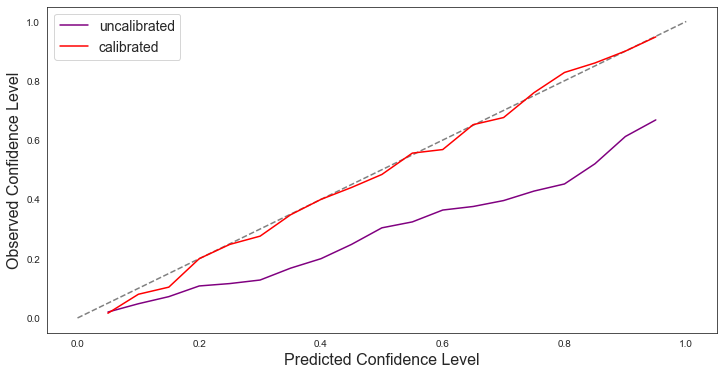

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

calib.plot_diagnostic_curve(ax, X_test, y_test);